In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score  # For evaluation metrics

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
!gdown --id 1HDJsbtPdGze_ZeA_W6wMTHXialbyGz7V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HDJsbtPdGze_ZeA_W6wMTHXialbyGz7V
From (redirected): https://drive.google.com/uc?id=1HDJsbtPdGze_ZeA_W6wMTHXialbyGz7V&confirm=t&uuid=0a2dbefe-a07b-4bbc-afad-9fe222fdf599
To: /kaggle/working/Brain Tumor Detection MRI.zip
100%|████████████████████████████████████████| 130M/130M [00:02<00:00, 60.6MB/s]


In [3]:
import zipfile
import os

# Path to the downloaded zip file
zip_path = "/kaggle/working/Brain Tumor Detection MRI.zip"
extract_dir = "/kaggle/working/base"

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted successfully!")

# Check contents
for root, dirs, files in os.walk(extract_dir):
    for name in files:
        print(os.path.join(root, name))
    break  # To avoid printing everything

Dataset extracted successfully!


In [4]:
import os

zip_path = "/kaggle/working/Augmented Data.zip"

# Check if the file exists before removing
if os.path.exists(zip_path):
    os.remove(zip_path)
    print("File removed successfully.")
else:
    print("File not found.")

File not found.


In [6]:
pip install torchcam

Note: you may need to restart the kernel to use updated packages.


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 207MB/s] 



Training ConvNeXt
Epoch 1/15 | Train Loss: 1.0687, Train Acc: 0.5738 | Val Loss: 0.6377, Val Acc: 0.8495
Epoch 2/15 | Train Loss: 0.5678, Train Acc: 0.8374 | Val Loss: 0.3378, Val Acc: 0.8985
Epoch 3/15 | Train Loss: 0.3721, Train Acc: 0.8797 | Val Loss: 0.2602, Val Acc: 0.9061
Epoch 4/15 | Train Loss: 0.2804, Train Acc: 0.9100 | Val Loss: 0.2079, Val Acc: 0.9306
Epoch 5/15 | Train Loss: 0.2343, Train Acc: 0.9285 | Val Loss: 0.1658, Val Acc: 0.9457
Epoch 6/15 | Train Loss: 0.1808, Train Acc: 0.9432 | Val Loss: 0.1381, Val Acc: 0.9527
Epoch 7/15 | Train Loss: 0.1417, Train Acc: 0.9567 | Val Loss: 0.1156, Val Acc: 0.9609
Epoch 8/15 | Train Loss: 0.1141, Train Acc: 0.9665 | Val Loss: 0.0956, Val Acc: 0.9644
Epoch 9/15 | Train Loss: 0.0971, Train Acc: 0.9695 | Val Loss: 0.0886, Val Acc: 0.9691
Epoch 10/15 | Train Loss: 0.0786, Train Acc: 0.9787 | Val Loss: 0.0843, Val Acc: 0.9708
Epoch 11/15 | Train Loss: 0.0704, Train Acc: 0.9812 | Val Loss: 0.0655, Val Acc: 0.9755
Epoch 12/15 | Train Lo

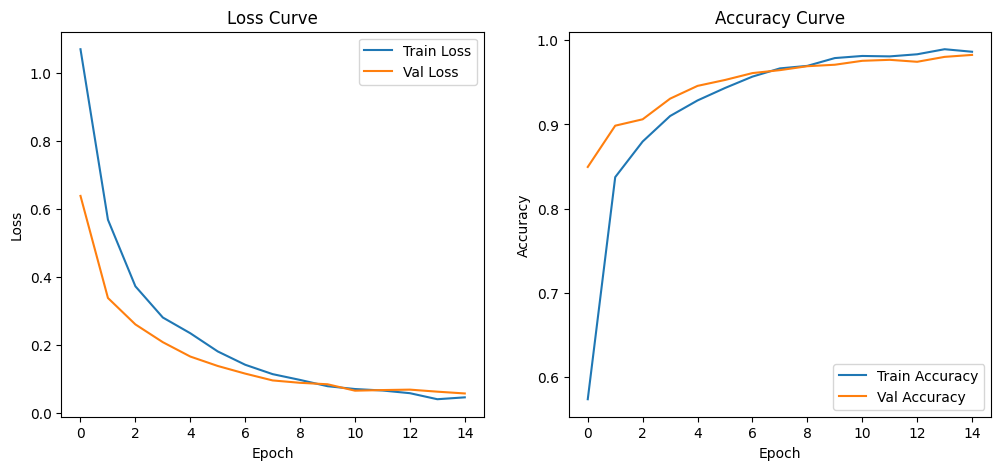


Classification Report:

              precision    recall  f1-score   support

           0     0.9894    0.9713    0.9802       383
           1     0.9431    0.9827    0.9625       405
           2     0.9957    0.9790    0.9873       477
           3     0.9866    0.9822    0.9844       449

    accuracy                         0.9790      1714
   macro avg     0.9787    0.9788    0.9786      1714
weighted avg     0.9795    0.9790    0.9791      1714



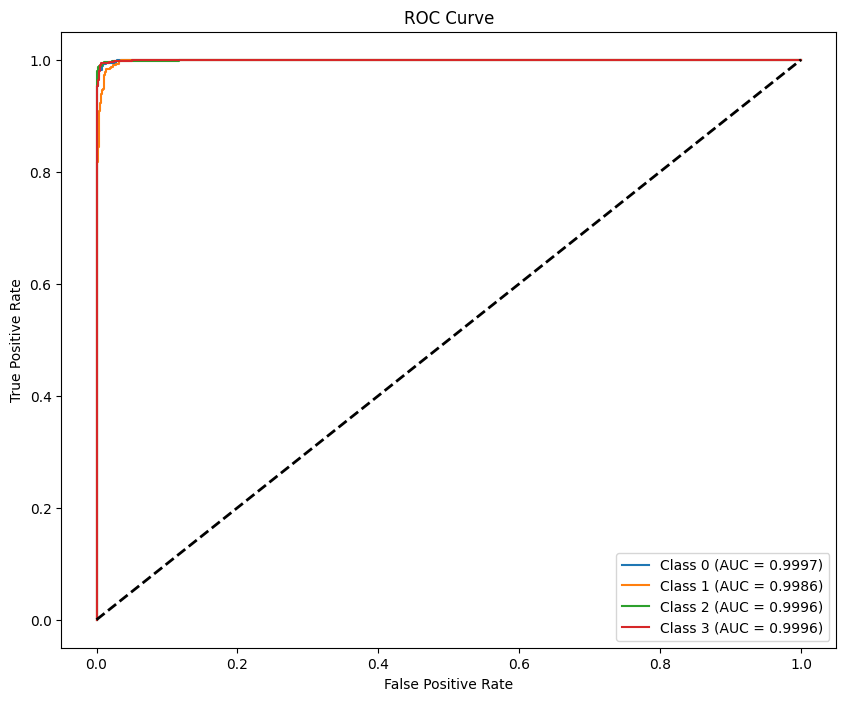

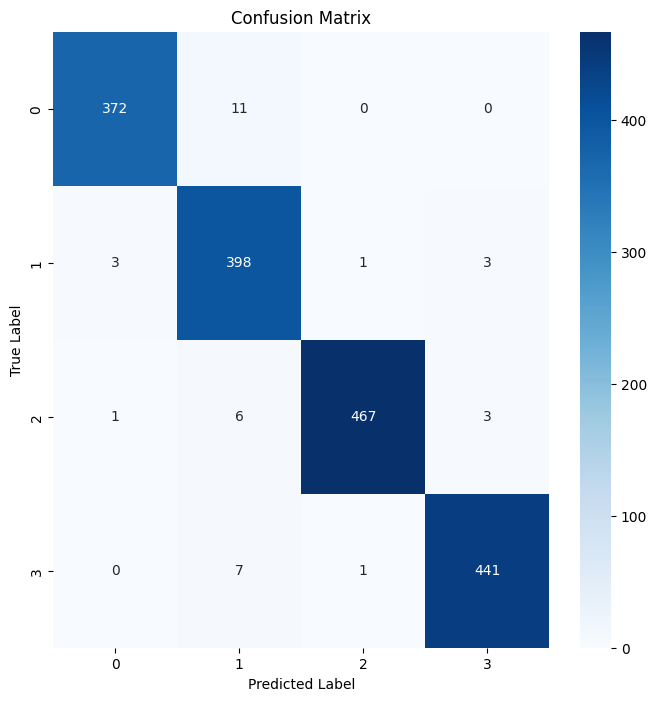

Training time: 5282.25 sec | Testing time: 32.39 sec


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import label_binarize

# -------------------- Data Augmentation & Preparation --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = '/kaggle/working/base/Training'  # Adjust path
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)

# Split into train and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# Calculate class weights for imbalanced dataset
targets = [dataset.targets[i] for i in range(len(dataset))]
class_counts = Counter(targets)
total_samples = len(dataset)

# Calculate class weights for training set
train_indices = train_set.indices
train_targets = [dataset.targets[i] for i in train_indices]
train_class_counts = Counter(train_targets)

# Create class weights for the weighted sampler
weights_train = [total_samples / train_class_counts[train_targets[i]] for i in range(len(train_targets))]
train_sampler = WeightedRandomSampler(weights_train, num_samples=len(weights_train), replacement=True)

# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = val_loader  

# -------------------- Model Definition with Dropout --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def get_model(model_name, num_classes, dropout_rate=0.5):
    model = getattr(models, model_name)(pretrained=True)
    
    if 'convnext' in model_name:
        # Add dropout before the final classifier layer
        num_features = model.classifier[2].in_features
        model.classifier = nn.Sequential(
            model.classifier[0],  # LayerNorm
            model.classifier[1],  # Flatten
            nn.Dropout(dropout_rate),  # Add dropout with rate 0.5
            nn.Linear(num_features, num_classes)  # Replace final linear layer
        )
    else:
        # For other models (e.g., ResNet, VGG)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),  # Add dropout with rate 0.5
            nn.Linear(num_features, num_classes)
        )

    return model.to(device)

model_name = 'convnext_base'
model = get_model(model_name, num_classes, dropout_rate=0.5)

# Define class weights for loss function
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(num_classes)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# -------------------- Training Function --------------------
def train_model(model, train_loader, val_loader, test_loader, max_epochs=20, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_train_time = time.time()

    for epoch in range(max_epochs):
        model.train()  # Set model to training mode (activates dropout)
        total_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()  # Set model to evaluation mode (deactivates dropout)
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                if best_state is not None:
                    model.load_state_dict(best_state)
                break

    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # -------------------- Plot Accuracy & Loss Curves --------------------
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

    # -------------------- Testing --------------------
    model.eval()  # Set model to evaluation mode (deactivates dropout)
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())  

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)  
    test_time = time.time() - end_train_time

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, digits=4))

    # -------------------- ROC-AUC Curve --------------------
    plt.figure(figsize=(10, 8))

    if num_classes == 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    else:
        # For multiclass, plot ROC curve for each class
        y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # -------------------- Confusion Matrix --------------------
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Training time: {train_time:.2f} sec | Testing time: {test_time:.2f} sec")

# -------------------- Training Execution --------------------
print(f"\nTraining {model.__class__.__name__}\n{'='*50}")
train_model(model, train_loader, val_loader, test_loader, max_epochs=15, patience=5)


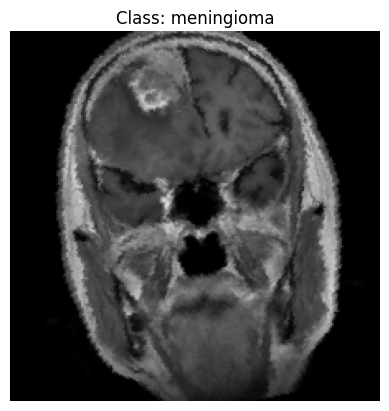

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch

# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load a sample dataset
dataset = ImageFolder(root='/kaggle/working/base/Training', transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Get a single batch
dataiter = iter(loader)
images, labels = next(dataiter)

# Denormalization function
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Denormalize and show
img = denormalize(images[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

plt.imshow(img.permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.title(f'Class: {dataset.classes[labels[0]]}')
plt.axis('off')
plt.show()

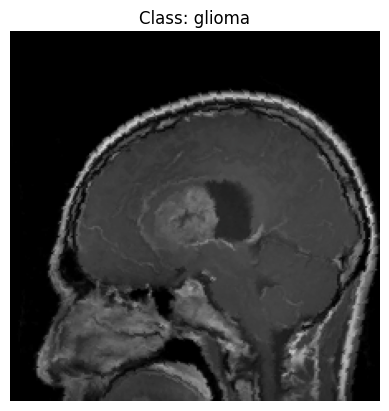

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch

# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load a sample dataset
dataset = ImageFolder(root='/kaggle/working/base/Training', transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Get a single batch
dataiter = iter(loader)
images, labels = next(dataiter)

# Denormalization function
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Denormalize and show
img = denormalize(images[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

plt.imshow(img.permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.title(f'Class: {dataset.classes[labels[0]]}')
plt.axis('off')
plt.show()

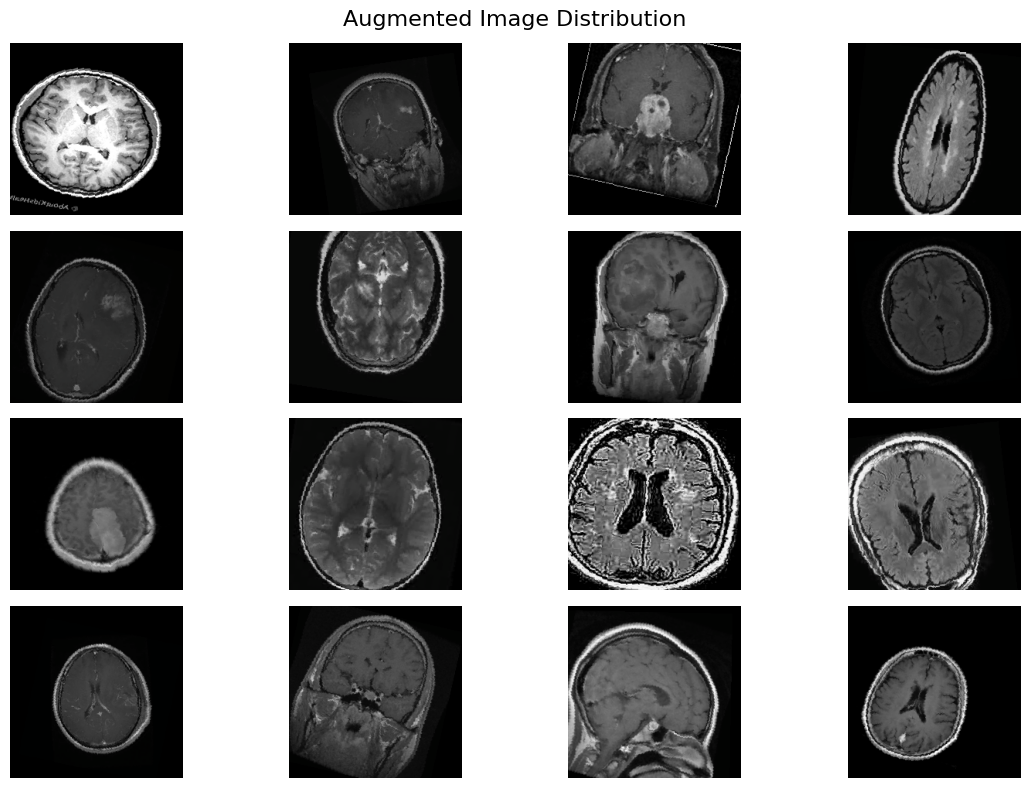

In [11]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Define your augmentation transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Also define an inverse normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# Load a sample dataset (replace this with your dataset path)
dataset = datasets.ImageFolder(root='/kaggle/working/base/Training', transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Get one batch of augmented images
data_iter = iter(loader)
images, labels = next(data_iter)

# Function to show images
def imshow(img):
    img = inv_normalize(img)  # unnormalize
    img = img.permute(1, 2, 0).numpy()  # CHW -> HWC
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Plot the first few augmented images
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
    plt.axis('off')
plt.suptitle("Augmented Image Distribution", fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
from torchvision import datasets
from collections import Counter

# Path to your dataset
data_dir = '/kaggle/working/base/Training'

# Load dataset (augmentation not needed for counting)
dataset = datasets.ImageFolder(root=data_dir)

# Get all class labels (0, 1, etc.)
labels = dataset.targets

# Count images per class
class_counts = Counter(labels)

# Get class names
class_names = dataset.classes

# Print results
for idx, class_name in enumerate(class_names):
    print(f"Class '{class_name}': {class_counts[idx]} images")

Class 'glioma': 1321 images
Class 'meningioma': 1339 images
Class 'notumor': 1595 images
Class 'pituitary': 1457 images


In [13]:
import os
from torchvision import datasets, transforms
from collections import Counter

# Path to your dataset
data_dir = '/kaggle/working/base/Training'

# Define the augmentation transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset (no need for augmentation for counting)
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Count images per class in the original dataset
class_counts = Counter(dataset.targets)

# Get class names
class_names = dataset.classes

# Find the class with the maximum number of images (to balance around it)
max_class_count = max(class_counts.values())

# Number of augmentations you want to apply to each image (this can be adjusted)
augmentations_per_image = 3  # E.g., 3 augmented versions per image

# Calculate the number of augmented images required for each class to match the largest class
augmented_class_counts = {}
for idx, class_name in enumerate(class_names):
    original_count = class_counts[idx]
    if original_count < max_class_count:
        # Calculate how many times to augment to reach the max class count
        augmentations_needed = (max_class_count - original_count) // augmentations_per_image
        augmented_class_counts[class_name] = original_count + augmentations_needed * augmentations_per_image
    else:
        augmented_class_counts[class_name] = original_count

# Print balanced results
print("Total number of images per class after balancing augmentation:")
for idx, class_name in enumerate(class_names):
    print(f"Class '{class_name}': {augmented_class_counts[class_name]} images")

# Calculate the total number of images in the augmented and balanced dataset
total_balanced_images = sum(augmented_class_counts.values())
print(f"\nTotal number of images in the augmented and balanced dataset: {total_balanced_images}")

Total number of images per class after balancing augmentation:
Class 'glioma': 1594 images
Class 'meningioma': 1594 images
Class 'notumor': 1595 images
Class 'pituitary': 1595 images

Total number of images in the augmented and balanced dataset: 6378


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 217MB/s]



Training resnext50_32x4d
Epoch 1/15 | Train Loss: 0.9090, Train Acc: 0.6513 | Val Loss: 0.4441, Val Acc: 0.8821
Epoch 2/15 | Train Loss: 0.4116, Train Acc: 0.8714 | Val Loss: 0.2435, Val Acc: 0.9177
Epoch 3/15 | Train Loss: 0.2794, Train Acc: 0.9082 | Val Loss: 0.1680, Val Acc: 0.9446
Epoch 4/15 | Train Loss: 0.2091, Train Acc: 0.9320 | Val Loss: 0.1104, Val Acc: 0.9650
Epoch 5/15 | Train Loss: 0.1602, Train Acc: 0.9547 | Val Loss: 0.0929, Val Acc: 0.9708
Epoch 6/15 | Train Loss: 0.1270, Train Acc: 0.9602 | Val Loss: 0.0786, Val Acc: 0.9755
Epoch 7/15 | Train Loss: 0.1027, Train Acc: 0.9672 | Val Loss: 0.0774, Val Acc: 0.9761
Epoch 8/15 | Train Loss: 0.0986, Train Acc: 0.9675 | Val Loss: 0.0656, Val Acc: 0.9772
Epoch 9/15 | Train Loss: 0.0657, Train Acc: 0.9797 | Val Loss: 0.0574, Val Acc: 0.9802
Epoch 10/15 | Train Loss: 0.0750, Train Acc: 0.9752 | Val Loss: 0.0638, Val Acc: 0.9813
Epoch 11/15 | Train Loss: 0.0559, Train Acc: 0.9845 | Val Loss: 0.0610, Val Acc: 0.9831
Epoch 12/15 | T

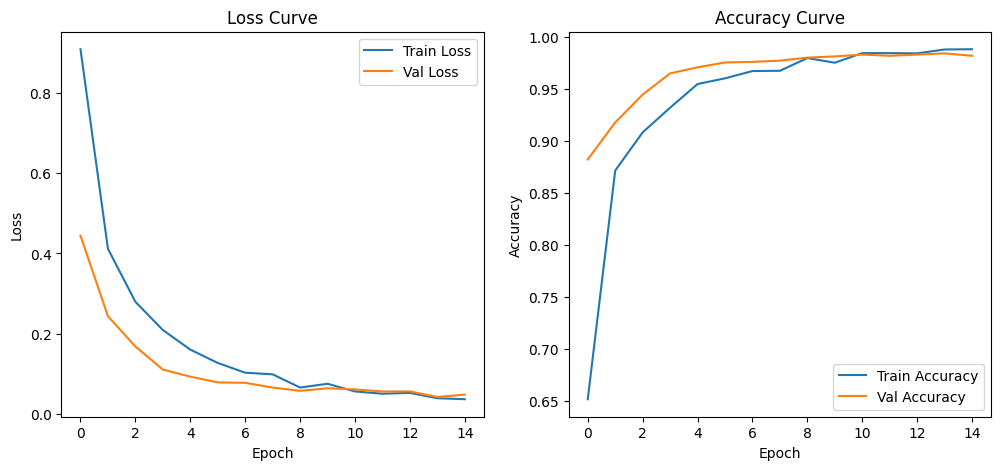


Classification Report:

              precision    recall  f1-score   support

           0     0.9843    0.9843    0.9843       383
           1     0.9676    0.9823    0.9749       395
           2     0.9979    0.9918    0.9949       487
           3     0.9955    0.9889    0.9922       449

    accuracy                         0.9872      1714
   macro avg     0.9863    0.9868    0.9866      1714
weighted avg     0.9873    0.9872    0.9872      1714



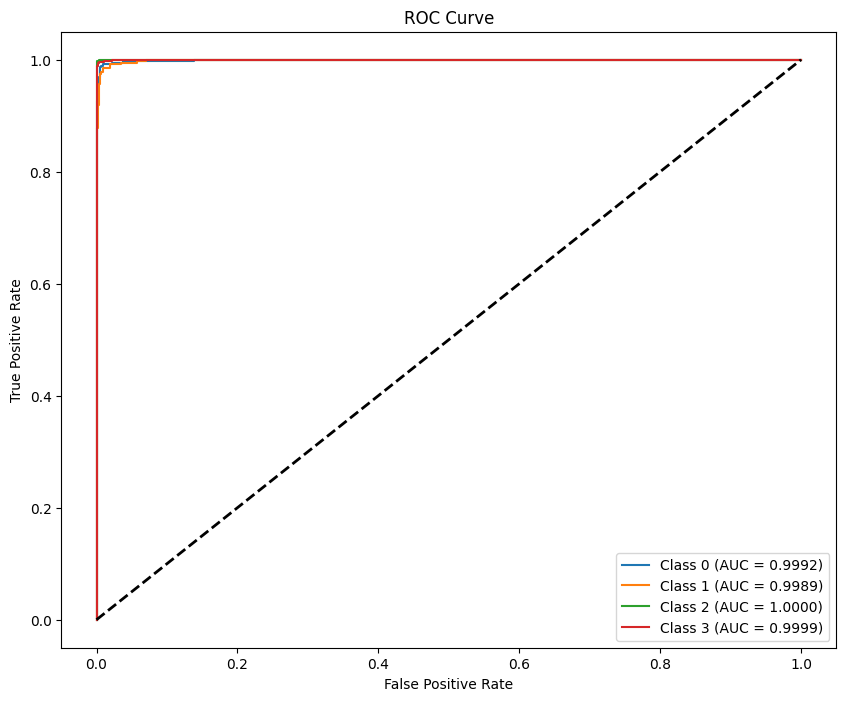

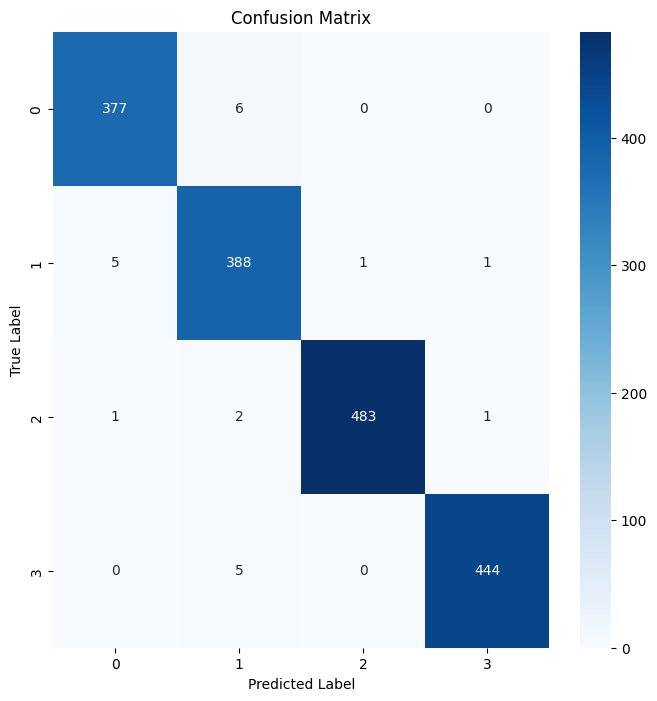

Training time: 1597.20 sec | Testing time: 18.27 sec


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# -------------------- Data Augmentation & Preparation --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = '/kaggle/working/base/Training'  # Adjust path as needed
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)

# Split into train and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create class weights for the weighted sampler
train_targets = [dataset.targets[i] for i in train_set.indices]
class_counts = Counter(train_targets)
total_samples = len(train_targets)
weights_train = [total_samples / class_counts[label] for label in train_targets]
train_sampler = WeightedRandomSampler(weights_train, num_samples=len(weights_train), replacement=True)

# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = val_loader  # For simplicity, test loader = val loader

# -------------------- Model Definition with Dropout --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def get_model(model_name, num_classes, dropout_rate=0.5):
    model = getattr(models, model_name)(pretrained=True)

    if 'resnext' in model_name or 'resnet' in model_name:
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )
    else:
        raise NotImplementedError(f"Model architecture '{model_name}' not currently supported.")
    
    return model.to(device)

model_name = 'resnext50_32x4d'
model = get_model(model_name, num_classes, dropout_rate=0.7)

# Define class weights for loss function
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(num_classes)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# -------------------- Training Function --------------------
def train_model(model, train_loader, val_loader, test_loader, max_epochs=20, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_train_time = time.time()

    for epoch in range(max_epochs):
        model.train()
        total_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                if best_state is not None:
                    model.load_state_dict(best_state)
                break

    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # -------------------- Plot Accuracy & Loss Curves --------------------
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    # -------------------- Testing --------------------
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    test_time = time.time() - end_train_time

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, digits=4))

    # -------------------- ROC-AUC Curve --------------------
    plt.figure(figsize=(10, 8))

    if num_classes == 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    else:
        y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # -------------------- Confusion Matrix --------------------
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Training time: {train_time:.2f} sec | Testing time: {test_time:.2f} sec")

# -------------------- Training Execution --------------------
print(f"\nTraining {model_name}\n{'='*50}")
train_model(model, train_loader, val_loader, test_loader, max_epochs=15, patience=5)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_800MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_800MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_800mf-1b27b58c.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-1b27b58c.pth
100%|██████████| 24.8M/24.8M [00:00<00:00, 33.7MB/s]



Training regnet_y_800mf
Epoch 1/15 | Train Loss: 1.4243, Train Acc: 0.3514 | Val Loss: 1.0326, Val Acc: 0.6161
Epoch 2/15 | Train Loss: 0.9976, Train Acc: 0.5860 | Val Loss: 0.6948, Val Acc: 0.8127
Epoch 3/15 | Train Loss: 0.7664, Train Acc: 0.7136 | Val Loss: 0.5217, Val Acc: 0.8547
Epoch 4/15 | Train Loss: 0.6184, Train Acc: 0.7696 | Val Loss: 0.4045, Val Acc: 0.8821
Epoch 5/15 | Train Loss: 0.5004, Train Acc: 0.8352 | Val Loss: 0.3486, Val Acc: 0.8938
Epoch 6/15 | Train Loss: 0.4241, Train Acc: 0.8522 | Val Loss: 0.2950, Val Acc: 0.9090
Epoch 7/15 | Train Loss: 0.3762, Train Acc: 0.8732 | Val Loss: 0.2769, Val Acc: 0.9067
Epoch 8/15 | Train Loss: 0.3347, Train Acc: 0.8902 | Val Loss: 0.2400, Val Acc: 0.9329
Epoch 9/15 | Train Loss: 0.2961, Train Acc: 0.9042 | Val Loss: 0.2161, Val Acc: 0.9265
Epoch 10/15 | Train Loss: 0.2842, Train Acc: 0.9042 | Val Loss: 0.1931, Val Acc: 0.9347
Epoch 11/15 | Train Loss: 0.2583, Train Acc: 0.9090 | Val Loss: 0.1899, Val Acc: 0.9399
Epoch 12/15 | Tr

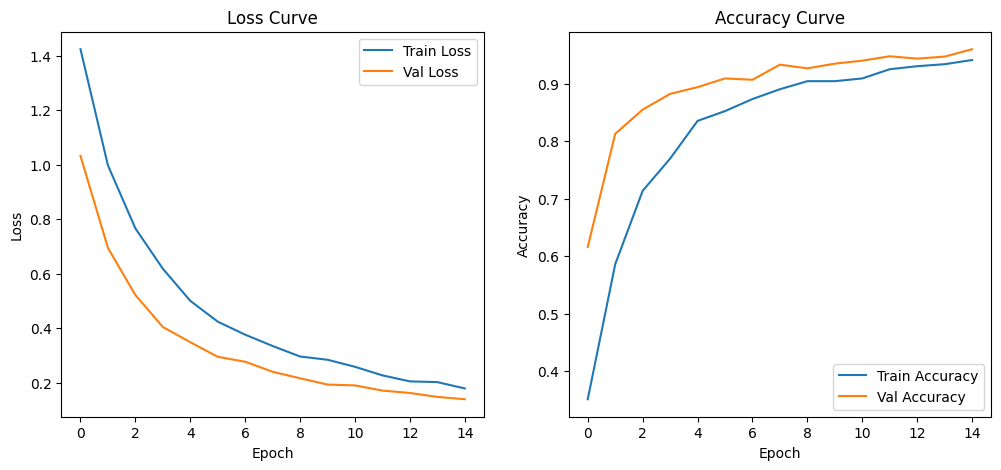


Classification Report:

              precision    recall  f1-score   support

           0     0.9443    0.9398    0.9420       415
           1     0.9096    0.8830    0.8961       376
           2     0.9844    0.9651    0.9747       459
           3     0.9362    0.9806    0.9579       464

    accuracy                         0.9452      1714
   macro avg     0.9436    0.9421    0.9427      1714
weighted avg     0.9452    0.9452    0.9450      1714



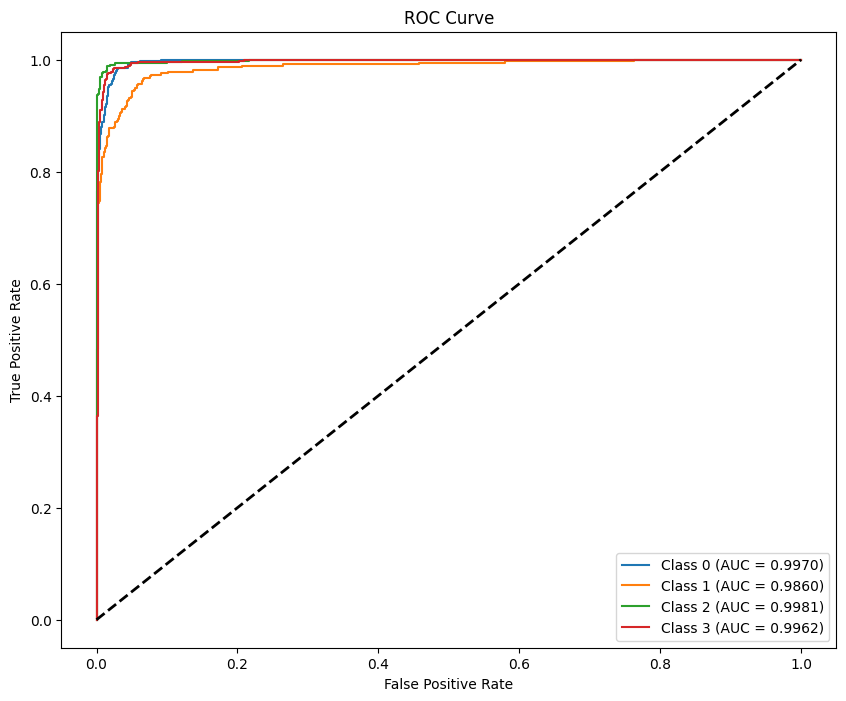

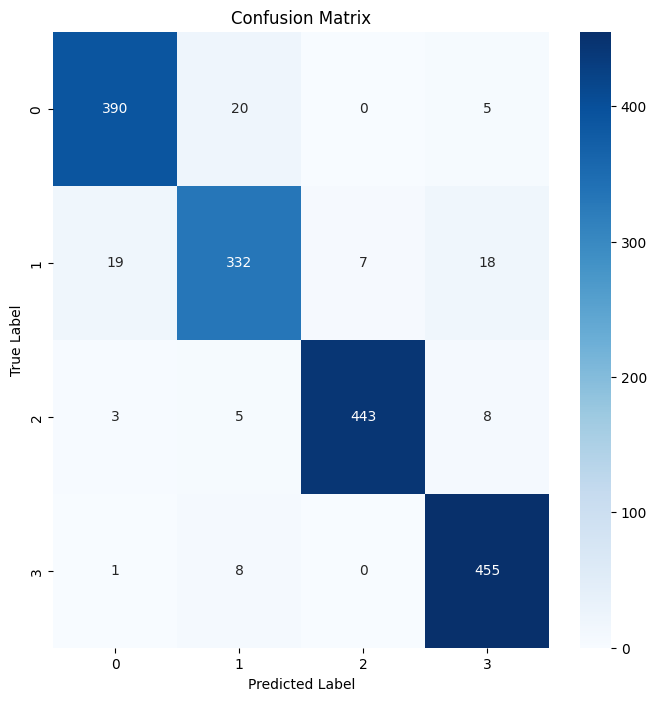

Training time: 894.63 sec | Testing time: 13.97 sec


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# -------------------- Data Augmentation & Preparation --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/kaggle/working/base/Training'  # Adjust path as needed
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_targets = [dataset.targets[i] for i in train_set.indices]
class_counts = Counter(train_targets)
total_samples = len(train_targets)
weights_train = [total_samples / class_counts[label] for label in train_targets]
train_sampler = WeightedRandomSampler(weights_train, num_samples=len(weights_train), replacement=True)

train_loader = DataLoader(train_set, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = val_loader

# -------------------- Model Definition with Dropout --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def get_model(model_name, num_classes, dropout_rate=0.5):
    model = getattr(models, model_name)(pretrained=True)

    if 'regnet' in model_name:
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )
    else:
        raise NotImplementedError(f"Model architecture '{model_name}' not currently supported.")

    return model.to(device)

model_name = 'regnet_y_800mf'
model = get_model(model_name, num_classes, dropout_rate=0.7)

class_weights = torch.tensor([1.0 / class_counts[i] for i in range(num_classes)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# -------------------- Training Function --------------------
def train_model(model, train_loader, val_loader, test_loader, max_epochs=20, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_train_time = time.time()

    for epoch in range(max_epochs):
        model.train()
        total_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                if best_state is not None:
                    model.load_state_dict(best_state)
                break

    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Plot Accuracy & Loss Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    # Testing
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    test_time = time.time() - end_train_time

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, digits=4))

    # ROC-AUC Curve
    plt.figure(figsize=(10, 8))

    if num_classes == 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    else:
        y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Training time: {train_time:.2f} sec | Testing time: {test_time:.2f} sec")

# -------------------- Training Execution --------------------
print(f"\nTraining {model_name}\n{'='*50}")
train_model(model, train_loader, val_loader, test_loader, max_epochs=15, patience=5)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training densenet201
Epoch 1/15 | Train Loss: 1.0110, Train Acc: 0.6201 | Val Loss: 0.5813, Val Acc: 0.8629
Epoch 2/15 | Train Loss: 0.5213, Train Acc: 0.8407 | Val Loss: 0.3420, Val Acc: 0.8985
Epoch 3/15 | Train Loss: 0.3426, Train Acc: 0.8959 | Val Loss: 0.2389, Val Acc: 0.9294
Epoch 4/15 | Train Loss: 0.2718, Train Acc: 0.9175 | Val Loss: 0.1780, Val Acc: 0.9492
Epoch 5/15 | Train Loss: 0.2036, Train Acc: 0.9360 | Val Loss: 0.1385, Val Acc: 0.9586
Epoch 6/15 | Train Loss: 0.1584, Train Acc: 0.9532 | Val Loss: 0.1222, Val Acc: 0.9644
Epoch 7/15 | Train Loss: 0.1398, Train Acc: 0.9597 | Val Loss: 0.1084, Val Acc: 0.9691
Epoch 8/15 | Train Loss: 0.1311, Train Acc: 0.9602 | Val Loss: 0.0942, Val Acc: 0.9743
Epoch 9/15 | Train Loss: 0.1050, Train Acc: 0.9677 | Val Loss: 0.0812, Val Acc: 0.9767
Epoch 10/15 | Train Loss: 0.0982, Train Acc: 0.9712 | Val Loss: 0.0694, Val Acc: 0.9796
Epoch 11/15 | Train Loss: 0.0723, Train Acc: 0.9837 | Val Loss: 0.0642, Val Acc: 0.9813
Epoch 12/15 | Train

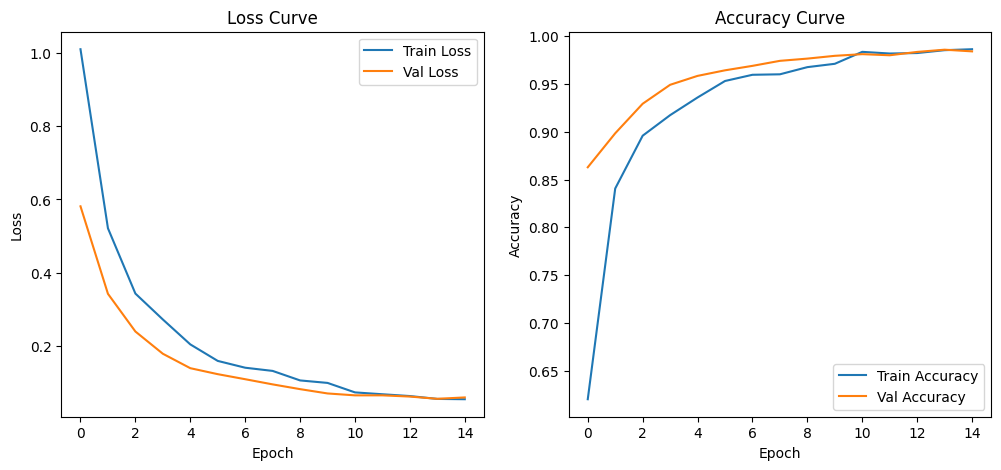


Classification Report:

              precision    recall  f1-score   support

           0     0.9800    0.9751    0.9776       402
           1     0.9660    0.9736    0.9698       379
           2     0.9921    0.9941    0.9931       505
           3     0.9906    0.9860    0.9883       428

    accuracy                         0.9831      1714
   macro avg     0.9822    0.9822    0.9822      1714
weighted avg     0.9831    0.9831    0.9831      1714



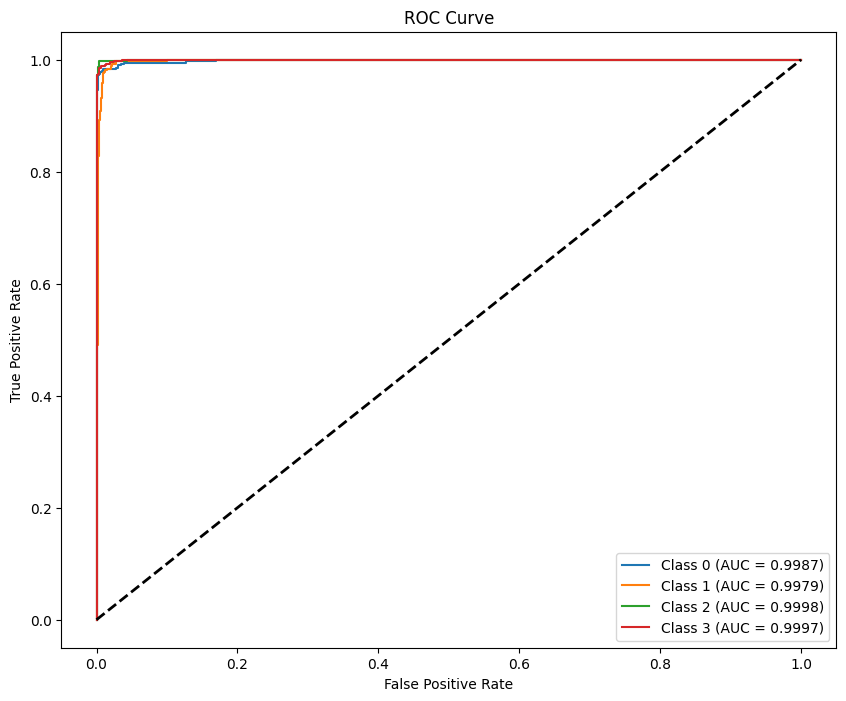

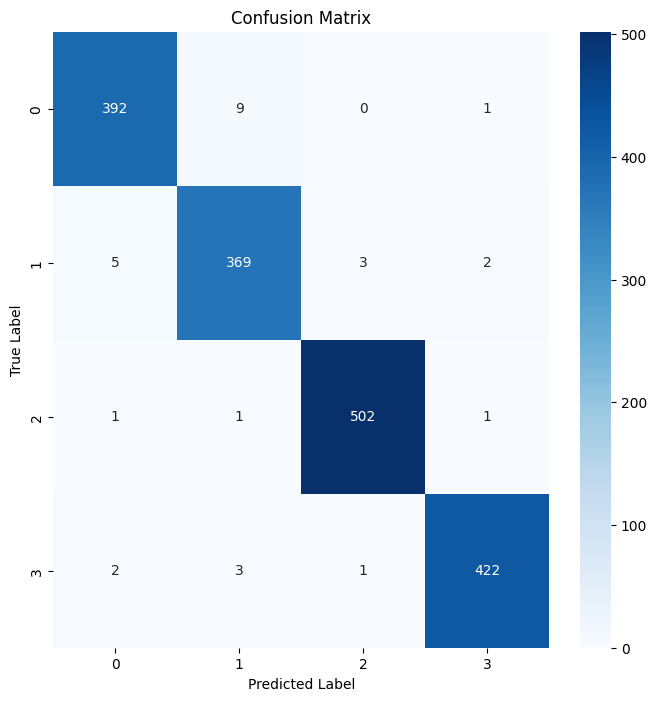

Training time: 1773.71 sec | Testing time: 21.15 sec


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# -------------------- Data Augmentation & Preparation --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/kaggle/working/base/Training'  # Adjust path if needed
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_targets = [dataset.targets[i] for i in train_set.indices]
class_counts = Counter(train_targets)
total_samples = len(train_targets)
weights_train = [total_samples / class_counts[label] for label in train_targets]
train_sampler = WeightedRandomSampler(weights_train, num_samples=len(weights_train), replacement=True)

train_loader = DataLoader(train_set, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = val_loader

# -------------------- Model Definition with Dropout --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def get_model(model_name, num_classes, dropout_rate=0.5):
    model = getattr(models, model_name)(pretrained=True)

    if 'densenet' in model_name:
        num_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )
    else:
        raise NotImplementedError(f"Model architecture '{model_name}' not currently supported.")

    return model.to(device)

model_name = 'densenet201'
model = get_model(model_name, num_classes, dropout_rate=0.5)

class_weights = torch.tensor([1.0 / class_counts[i] for i in range(num_classes)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# -------------------- Training Function --------------------
def train_model(model, train_loader, val_loader, test_loader, max_epochs=20, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_train_time = time.time()

    for epoch in range(max_epochs):
        model.train()
        total_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                if best_state is not None:
                    model.load_state_dict(best_state)
                break

    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Plot Accuracy & Loss Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    # Testing
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    test_time = time.time() - end_train_time

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, digits=4))

    # ROC-AUC Curve
    plt.figure(figsize=(10, 8))

    if num_classes == 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    else:
        y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Training time: {train_time:.2f} sec | Testing time: {test_time:.2f} sec")

# -------------------- Training Execution --------------------
print(f"\nTraining {model_name}\n{'='*50}")
train_model(model, train_loader, val_loader, test_loader, max_epochs=15, patience=5)

Using device: cuda

Training EfficientNet
Epoch 1/15 | Train Loss: 1.2976, Train Acc: 0.4260 | Val Loss: 1.1101, Val Acc: 0.7170
Epoch 2/15 | Train Loss: 0.9527, Train Acc: 0.7199 | Val Loss: 0.6639, Val Acc: 0.8384
Epoch 3/15 | Train Loss: 0.5946, Train Acc: 0.8287 | Val Loss: 0.4167, Val Acc: 0.8810
Epoch 4/15 | Train Loss: 0.4408, Train Acc: 0.8597 | Val Loss: 0.3257, Val Acc: 0.8961
Epoch 5/15 | Train Loss: 0.3474, Train Acc: 0.8879 | Val Loss: 0.2786, Val Acc: 0.9102
Epoch 6/15 | Train Loss: 0.2996, Train Acc: 0.8967 | Val Loss: 0.2409, Val Acc: 0.9253
Epoch 7/15 | Train Loss: 0.2450, Train Acc: 0.9155 | Val Loss: 0.1890, Val Acc: 0.9434
Epoch 8/15 | Train Loss: 0.2169, Train Acc: 0.9260 | Val Loss: 0.1589, Val Acc: 0.9475
Epoch 9/15 | Train Loss: 0.1967, Train Acc: 0.9352 | Val Loss: 0.1403, Val Acc: 0.9516
Epoch 10/15 | Train Loss: 0.1653, Train Acc: 0.9437 | Val Loss: 0.1301, Val Acc: 0.9592
Epoch 11/15 | Train Loss: 0.1351, Train Acc: 0.9535 | Val Loss: 0.1143, Val Acc: 0.9632

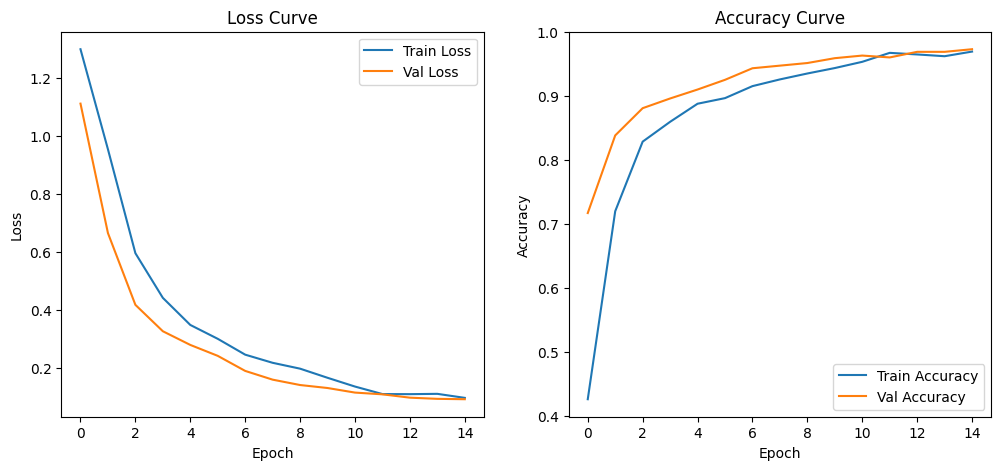


Classification Report:

              precision    recall  f1-score   support

           0     0.9675    0.9675    0.9675       400
           1     0.9477    0.9614    0.9545       415
           2     0.9935    0.9829    0.9882       468
           3     0.9837    0.9814    0.9826       431

    accuracy                         0.9737      1714
   macro avg     0.9731    0.9733    0.9732      1714
weighted avg     0.9739    0.9737    0.9738      1714



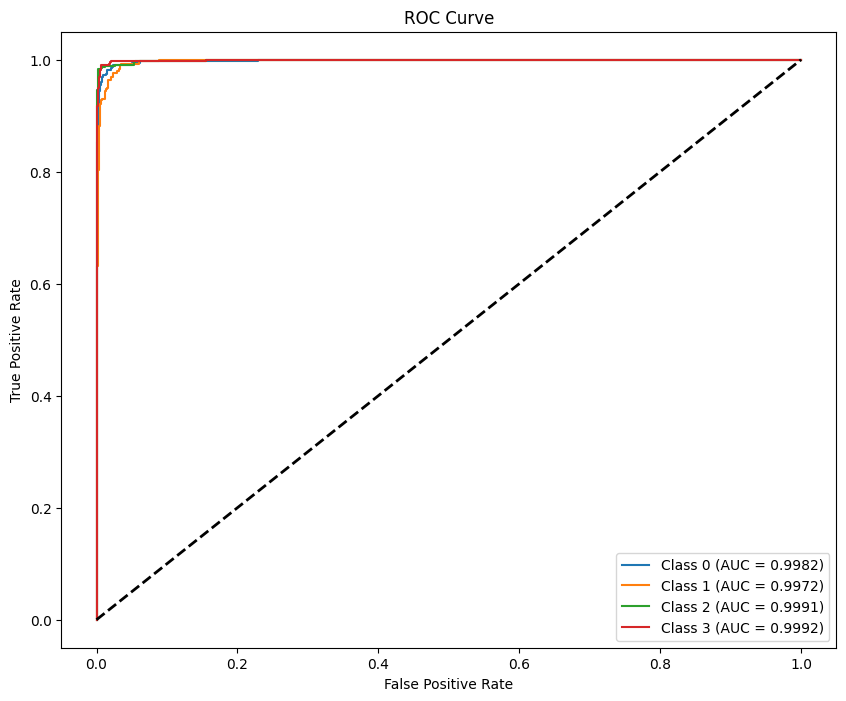

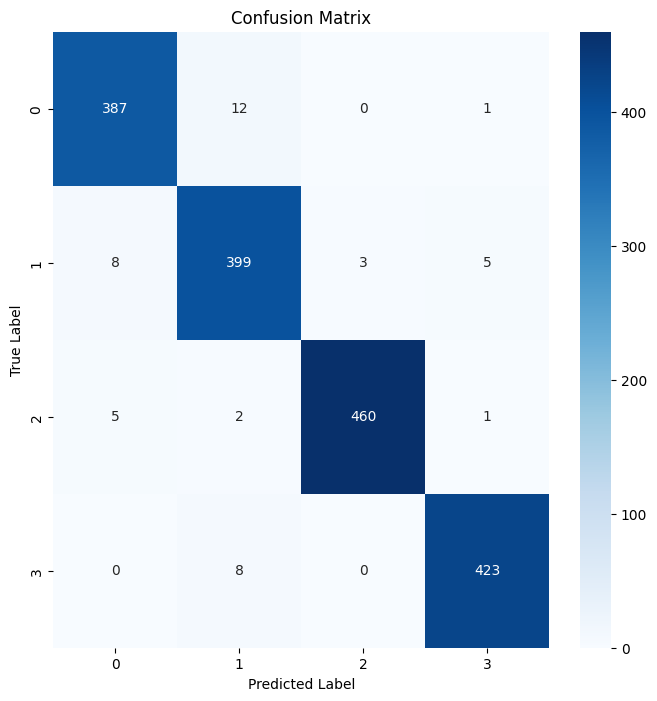

Training time: 1392.92 sec | Testing time: 16.66 sec


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import label_binarize

# -------------------- Data Augmentation & Preparation --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = '/kaggle/working/base/Training'  # Adjust path
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)

# Split into train and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# Calculate class weights for imbalanced dataset
targets = [dataset.targets[i] for i in range(len(dataset))]
class_counts = Counter(targets)
total_samples = len(dataset)

# Calculate class weights for training set
train_indices = train_set.indices
train_targets = [dataset.targets[i] for i in train_indices]
train_class_counts = Counter(train_targets)

# Create class weights for the weighted sampler
weights_train = [total_samples / train_class_counts[train_targets[i]] for i in range(len(train_targets))]
train_sampler = WeightedRandomSampler(weights_train, num_samples=len(weights_train), replacement=True)

# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = val_loader  

# -------------------- Model Definition with Dropout --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def get_model(model_name, num_classes, dropout_rate=0.5):
    model = getattr(models, model_name)(weights='DEFAULT')

    if 'efficientnet' in model_name:
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )
    else:
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    return model.to(device)

model_name = 'efficientnet_v2_s'
model = get_model(model_name, num_classes, dropout_rate=0.5)

# Define class weights for loss function
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(num_classes)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# -------------------- Training Function --------------------
def train_model(model, train_loader, val_loader, test_loader, max_epochs=20, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_train_time = time.time()

    for epoch in range(max_epochs):
        model.train()
        total_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                if best_state is not None:
                    model.load_state_dict(best_state)
                break

    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # -------------------- Plot Accuracy & Loss Curves --------------------
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    # -------------------- Testing --------------------
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())  

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)  
    test_time = time.time() - end_train_time

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, digits=4))

    # -------------------- ROC-AUC Curve --------------------
    plt.figure(figsize=(10, 8))

    if num_classes == 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    else:
        y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # -------------------- Confusion Matrix --------------------
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Training time: {train_time:.2f} sec | Testing time: {test_time:.2f} sec")

# -------------------- Training Execution --------------------
print(f"\nTraining {model.__class__.__name__}\n{'='*50}")
train_model(model, train_loader, val_loader, test_loader, max_epochs=15, patience=5)

Number of classes: 4
Using device: cuda

Training CustomNASNetLarge
CustomNASNetLarge Epoch 1/15 | Train Loss: 0.8309, Train Acc: 0.6951 | Val Loss: 0.2928, Val Acc: 0.9037
CustomNASNetLarge Epoch 2/15 | Train Loss: 0.3357, Train Acc: 0.8942 | Val Loss: 0.1450, Val Acc: 0.9522
CustomNASNetLarge Epoch 3/15 | Train Loss: 0.2286, Train Acc: 0.9237 | Val Loss: 0.1095, Val Acc: 0.9667
CustomNASNetLarge Epoch 4/15 | Train Loss: 0.1494, Train Acc: 0.9557 | Val Loss: 0.0871, Val Acc: 0.9732
CustomNASNetLarge Epoch 5/15 | Train Loss: 0.1165, Train Acc: 0.9650 | Val Loss: 0.0644, Val Acc: 0.9790
CustomNASNetLarge Epoch 6/15 | Train Loss: 0.0907, Train Acc: 0.9720 | Val Loss: 0.0703, Val Acc: 0.9796
CustomNASNetLarge Epoch 7/15 | Train Loss: 0.0689, Train Acc: 0.9795 | Val Loss: 0.0758, Val Acc: 0.9807
CustomNASNetLarge Epoch 8/15 | Train Loss: 0.0588, Train Acc: 0.9835 | Val Loss: 0.0649, Val Acc: 0.9790
CustomNASNetLarge Epoch 9/15 | Train Loss: 0.0479, Train Acc: 0.9882 | Val Loss: 0.0699, Val

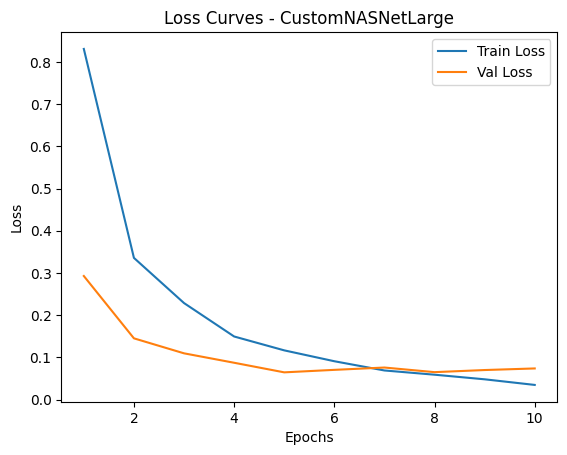

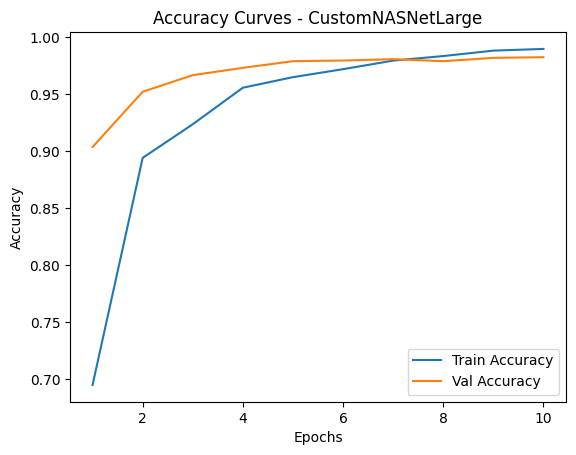

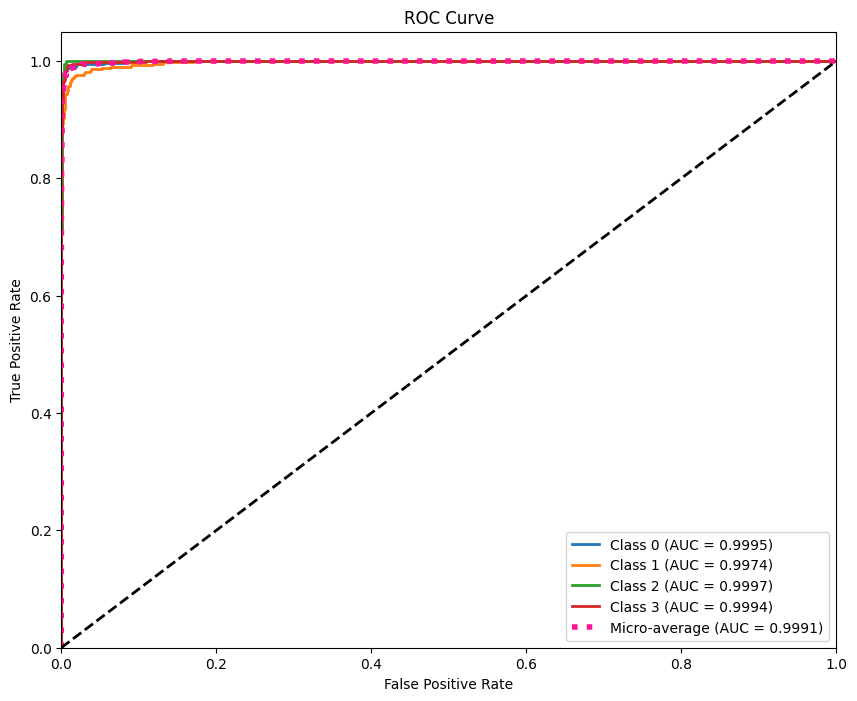

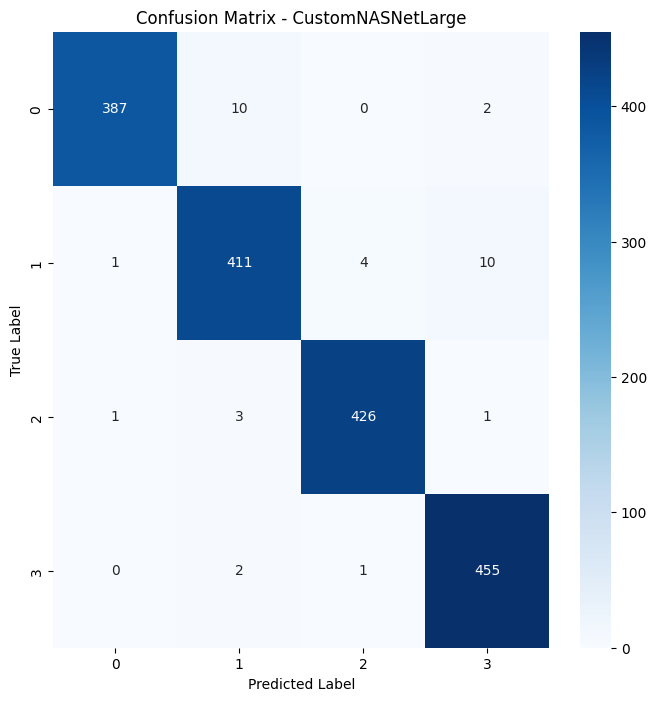

Training time: 748.95 sec | Testing time: 11.67 sec


In [19]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import torchvision.models as models

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loss function
criterion = nn.CrossEntropyLoss()

# Data path
data_dir = '/kaggle/working/base/Training'

# Load and split dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = val_loader

print("Number of classes:", num_classes)

# Device configuration
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_tensor = torch.zeros((1, 3, 224, 224), device=device)
    test_tensor = None
    print("Using device:", device)
except:
    device = torch.device("cpu")
    print("CUDA out of memory, falling back to CPU")
    print("Using device:", device)

# Custom NASNet-like model using ResNet50
class CustomNASNetLarge(nn.Module):
    def __init__(self, num_classes):
        super(CustomNASNetLarge, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        self.__class__.__name__ = "CustomNASNetLarge"

    def forward(self, x):
        features = self.base_model(x)
        return self.classifier(features)

def get_custom_nasnet(num_classes):
    model = CustomNASNetLarge(num_classes)
    return model.to(device)

# Model list
model_names = ['custom_nasnet_large']
models_list = [get_custom_nasnet(num_classes)]

# Training and evaluation
def train_model(model, train_loader, val_loader, test_loader, max_epochs=5, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    best_val_loss = float('inf')
    patience_counter, best_state = 0, None
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    start_train_time = time.time()

    for epoch in range(max_epochs):
        model.train()
        total_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"{model.__class__.__name__} Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered for {model.__class__.__name__} after {epoch+1} epochs")
                if best_state is not None:
                    model.load_state_dict(best_state)
                break

    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Testing
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    test_time = time.time() - end_train_time

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, digits=4))

    # Plot losses
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curves - {model.__class__.__name__}')
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Accuracy Curves - {model.__class__.__name__}')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(10, 8))
    if num_classes > 2:
        y_test_bin = label_binarize(all_labels, classes=np.arange(num_classes))
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.4f})')
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})',
                 color='deeppink', linestyle=':', linewidth=4)
    else:
        y_test_bin = label_binarize(all_labels, classes=[0, 1]).ravel()
        probs_for_positive = all_probs[:, 1] if all_probs.shape[1] > 1 else all_probs.ravel()
        fpr, tpr, _ = roc_curve(y_test_bin, probs_for_positive)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(num_classes),
                yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()

    print(f"Training time: {train_time:.2f} sec | Testing time: {test_time:.2f} sec")

    return {
        'model_name': model.__class__.__name__,
        'train_time': train_time,
        'test_time': test_time,
        'final_val_acc': val_accuracies[-1],
        'micro_auc': roc_auc["micro"] if num_classes > 2 else roc_auc
    }

# Train and evaluate all models
results = []
for model in models_list:
    print(f"\n{'='*50}\nTraining {model.__class__.__name__}\n{'='*50}")
    metrics = train_model(model, train_loader, val_loader, test_loader, max_epochs=15, patience=5)
    results.append(metrics)

# Compare results
if len(results) > 1:
    print("\nModel Comparison:")
    for result in results:
        print(f"Model: {result['model_name']}, Val Acc: {result['final_val_acc']:.4f}, Micro-AUC: {result['micro_auc']:.4f}, Train Time: {result['train_time']:.2f}s")

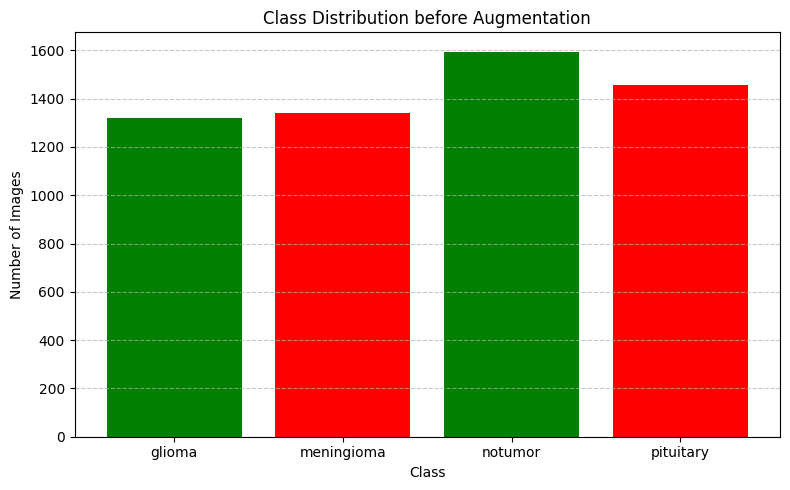

In [14]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

# Path to the augmented dataset
augmented_dir = '/kaggle/working/base/Training'

# Load dataset to get class distribution
final_dataset = datasets.ImageFolder(root=augmented_dir)
final_counts = Counter(final_dataset.targets)
class_names = final_dataset.classes  # ['glioma', 'meningioma','notumor','pituitary']

# Get counts in correct order
counts = [final_counts[i] for i in range(len(class_names))]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(class_names, counts, color=['green', 'red'])
plt.title("Class Distribution before Augmentation")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

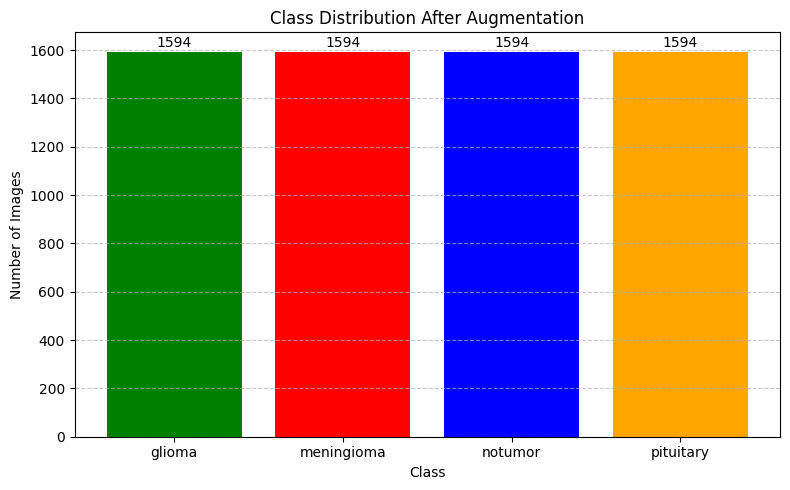

In [15]:
import matplotlib.pyplot as plt

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Replace these with actual image counts per class after augmentation
counts = [1594, 1594, 1594, 1594]  # All classes balanced

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(class_names, counts, color=['green', 'red', 'blue', 'orange'])
plt.title("Class Distribution After Augmentation")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

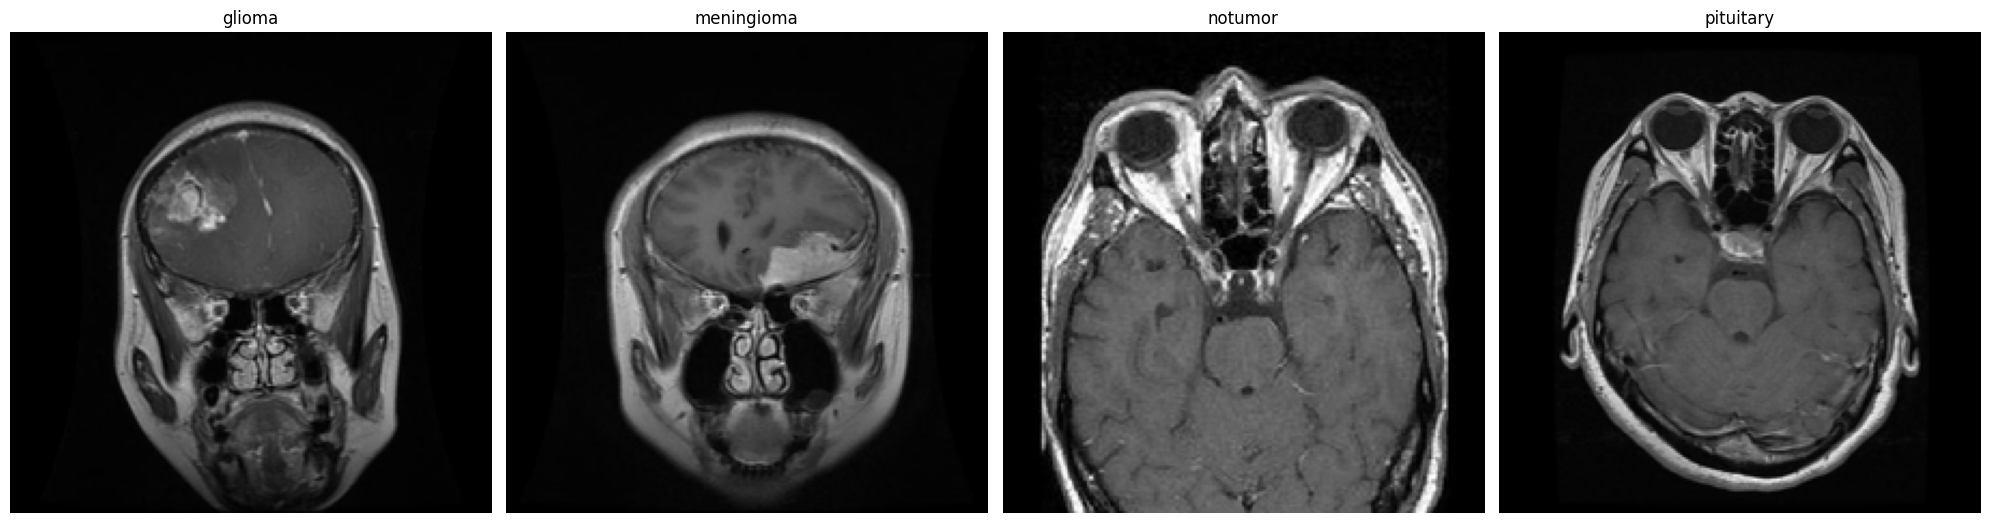

In [16]:
import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from PIL import Image

# Path to the dataset directory
data_dir = '/kaggle/working/base/Training'

# Load dataset
dataset = ImageFolder(root=data_dir)

# Create a plot with one image for each class
num_classes = len(dataset.classes)
fig, axes = plt.subplots(1, num_classes, figsize=(20, 10))

# For each class, select an image, resize it to 224x224, and display it
for idx, class_name in enumerate(dataset.classes):
    # Get the indices of images belonging to the current class
    class_indices = [i for i, (_, label) in enumerate(dataset.samples) if dataset.classes[label] == class_name]

    # Select the first image from the class
    img_path, _ = dataset.samples[class_indices[0]]

    # Open the image, resize it to 224x224, and show it
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to 224x224
    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 177MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args

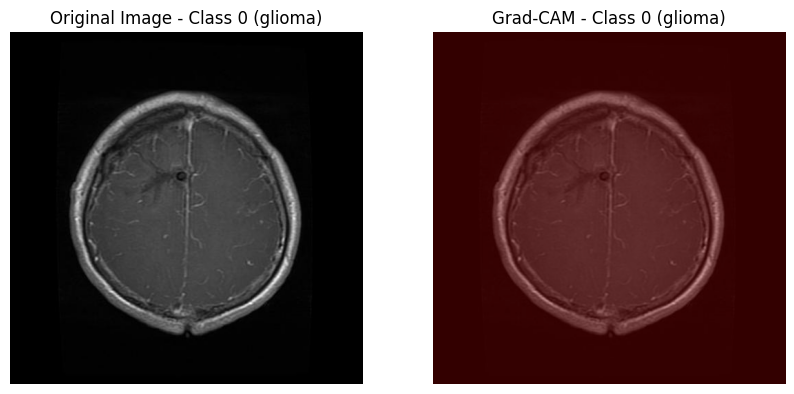

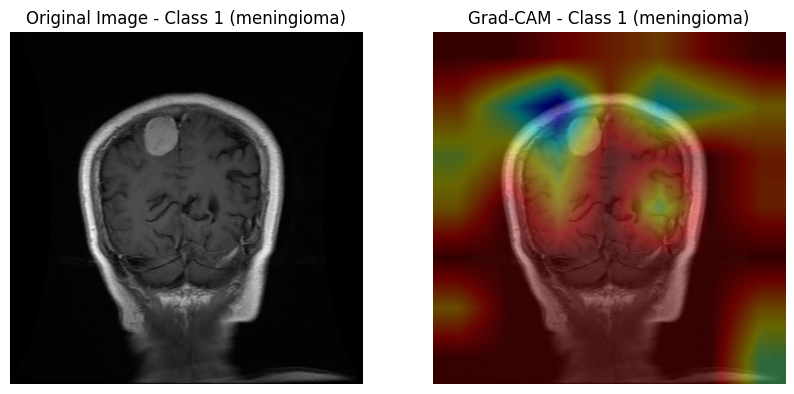

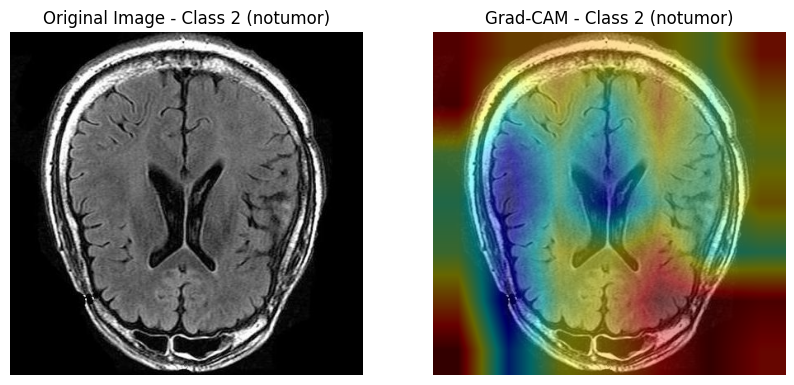

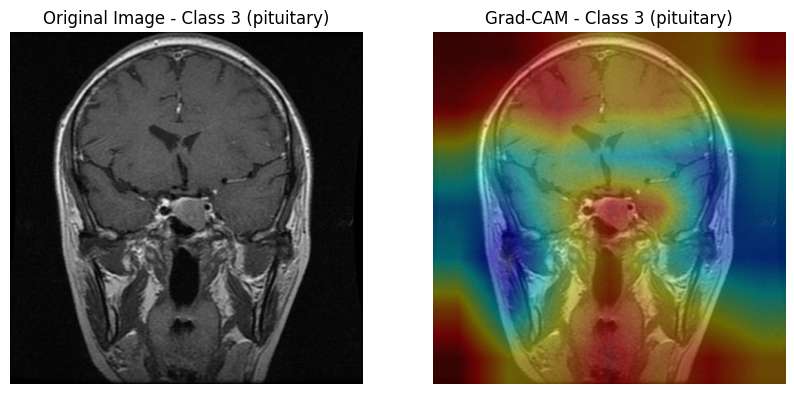

In [17]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import DataLoader
import random
import os

# Define the transformation for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Grad-CAM Visualization function for a random image from each class
def visualize_gradcam_for_random_class_images(dataset, model, target_layer):
    model.eval()  # Set model to evaluation mode

    # Randomly select one image per class
    class_indices = list(range(len(dataset.classes)))
    random_images = {}

    # Select a random image for each class
    for class_idx in class_indices:
        class_dir = os.path.join(dataset.root, dataset.classes[class_idx])
        all_images = os.listdir(class_dir)
        random_image = random.choice(all_images)
        random_images[class_idx] = os.path.join(class_dir, random_image)

    grads, acts = None, None

    # Define forward hook to capture activations
    def forward_hook(module, inp, out):
        nonlocal acts
        acts = out.detach()

    # Define backward hook to capture gradients
    def backward_hook(module, gin, gout):
        nonlocal grads
        grads = gout[0].detach()

    # Loop through each random class image and visualize Grad-CAM
    for class_idx, img_path in random_images.items():
        # Load image and preprocess
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)  # Apply transformations and move to device

        # Register hooks for the target layer
        hook_f = target_layer.register_forward_hook(forward_hook)
        hook_b = target_layer.register_backward_hook(backward_hook)

        # Zero the gradients, perform a forward pass, and then backward pass
        model.zero_grad()
        out = model(input_tensor)

        # Get the probabilities for all classes
        probs = torch.nn.functional.softmax(out, dim=1)

        # Perform backward pass for the current class
        out[:, class_idx].backward()

        # Perform Grad-CAM calculation
        pooled_grad = grads.mean([0, 2, 3])  # Global average pooling of gradients
        cam = (acts[0] * pooled_grad[:, None, None]).sum(0).relu()  # Element-wise multiplication and summing
        cam = cam / cam.max()  # Normalize the CAM

        # Remove hooks to prevent memory leaks
        hook_f.remove()
        hook_b.remove()

        # Resize the heatmap to the original image size
        heatmap = cv2.resize(cam.cpu().numpy(), (img.width, img.height))

        # Apply the heatmap to the image
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)  # Combine heatmap with the original image

        # Plot the original image and the Grad-CAM overlay for this class
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Original Image - Class {class_idx} ({dataset.classes[class_idx]})')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(overlay)
        plt.title(f'Grad-CAM - Class {class_idx} ({dataset.classes[class_idx]})')
        plt.axis('off')

        plt.show()

# Example usage:
data_dir = '/kaggle/working/base/Training'  # Path to dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnext50_32x4d(pretrained=True).to(device)  # Replace with the model you're using
target_layer = model.layer4[-1]  # Define the target layer (e.g., last layer of ResNext50)

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Visualize Grad-CAM for random image from each class
visualize_gradcam_for_random_class_images(dataset, model, target_layer)
